In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
import seaborn as sns
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import joblib 
from sklearn.svm import SVC 
from imblearn.over_sampling import SMOTE 
from ucimlrepo import fetch_ucirepo

#### Fetch the data from the UCI repo, the data comes in as two dataframes, one for features and one for the targets. We then concat them together to allow us to do some exploratory data analysis

In [49]:
data = fetch_ucirepo(id=2)

X = data.data.features 
y = data.data.targets 

data = pd.concat([X, y], axis=1)

data.to_csv('raw_data.csv')

#### The below EDA came from my notebook submitted as part of the group coursework

#### Exploratory Data Analysis

In [50]:
print(f'Shape of Dataset - {data.shape}')
print('--------------------------------------')

Shape of Dataset - (48842, 15)
--------------------------------------


In [51]:
print('Missing Values in Dataset')
print(data.isnull().sum())
print('--------------------------------------')

Missing Values in Dataset
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64
--------------------------------------


In [52]:
print('Summary statistics of the dataset')
print(data.describe())

Summary statistics of the dataset
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### Using ? to replace blank values is a method found in a paper by Chakrabarty and Biswas (2018), the default marker reduces amount of data lost with the use of a unique category

In [54]:
data.fillna('?', inplace=True)

data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

#### Income value counts highlighted some issues with the data, we are expecting two different values but due to some formatting issues there are actually four different values. We clean the data to ensure we have the two values as expected

In [55]:
data['income'].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [56]:
data.loc[data['income'] == '<=50K.', 'income'] = '<=50K'
data.loc[data['income'] == '>50K.', 'income'] = '>50K'

In [57]:
data['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

#### Description of the numerical columns 

In [58]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


#### Description of only the categorical columns

In [59]:
data.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


#### Plotting the spread of high and low income values in the target column

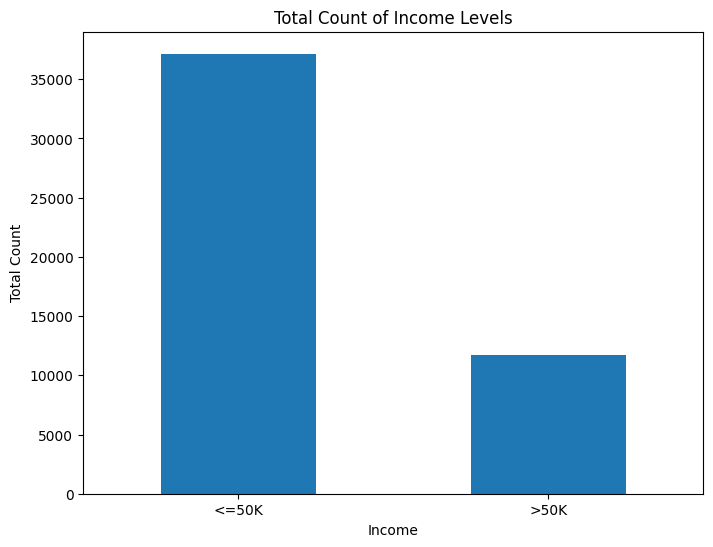

In [60]:
totals = data['income'].value_counts()

plt.figure(figsize=(8, 6))
totals.plot(kind='bar')
plt.title('Total Count of Income Levels')
plt.xlabel('Income')
plt.ylabel('Total Count')
plt.xticks(rotation=0)
plt.show()

#### Identifying correlation between the features

<Axes: >

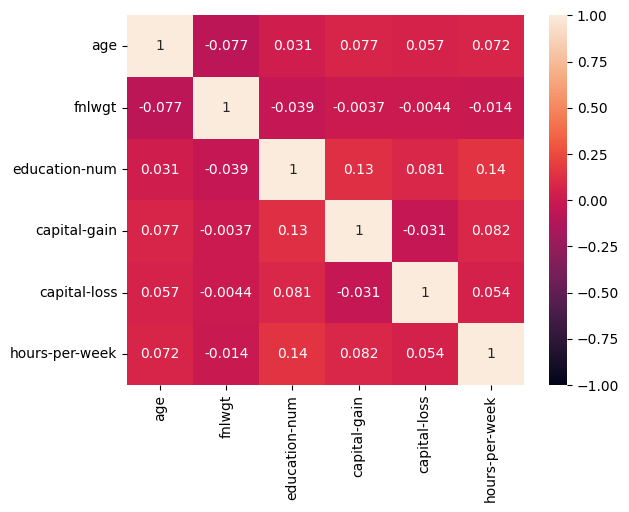

In [61]:
data_num = data.select_dtypes(include=np.number)
sns.heatmap(data_num.corr(), annot=True, vmin=-1, vmax=1)

#### Box and whisker plots to identify the distribution of the data and outliers

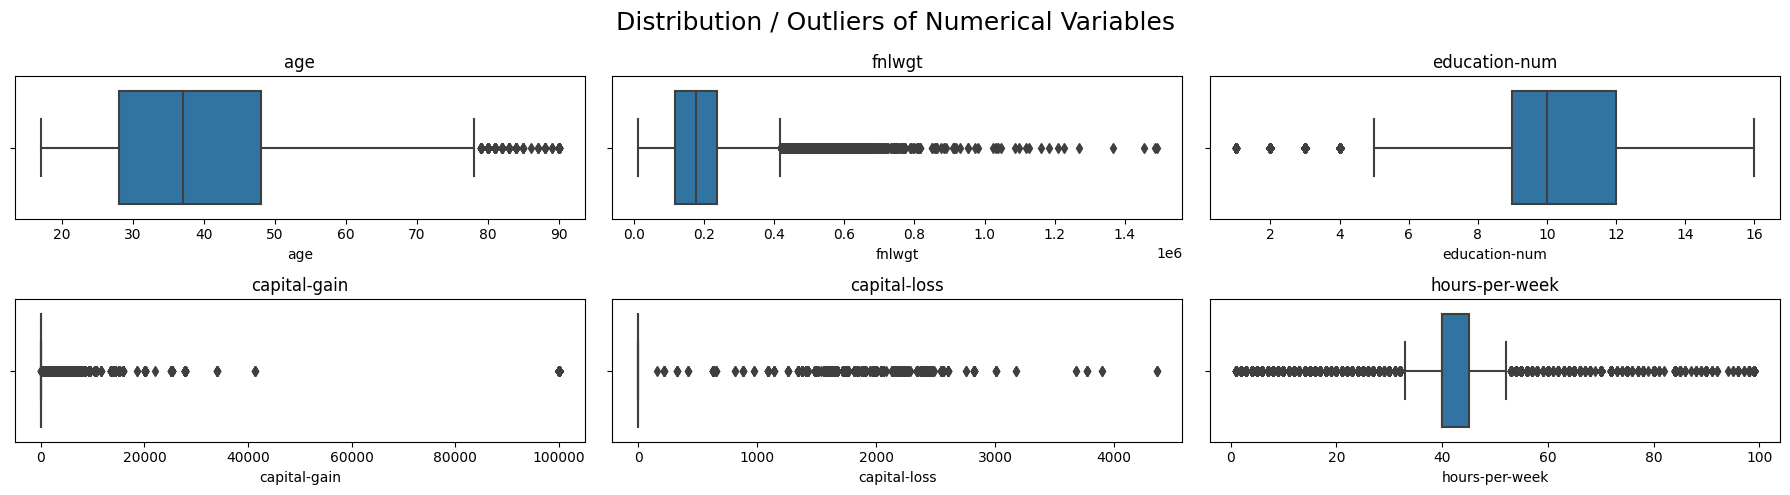

In [62]:
def plot_boxplot(data):
    
    numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
    number_plots = len(numeric_columns)
    number_rows = (number_plots + 5) // 6
    
    fig, axis = plt.subplots(2, 3, figsize=(18, 5 * number_rows))
    fig.suptitle('Distribution / Outliers of Numerical Variables', fontsize=18)
    
    axis = axis.flatten() if number_rows == 1 else axis
    
    for i, column in enumerate(numeric_columns):
        sns.boxplot(x=data[column], ax=axis[i])
        axis[i].set_title(column)
    
    plt.tight_layout()
    plt.show()

plot_boxplot(data)

#### Plotting the categorical columns, to help identify the spread of the data

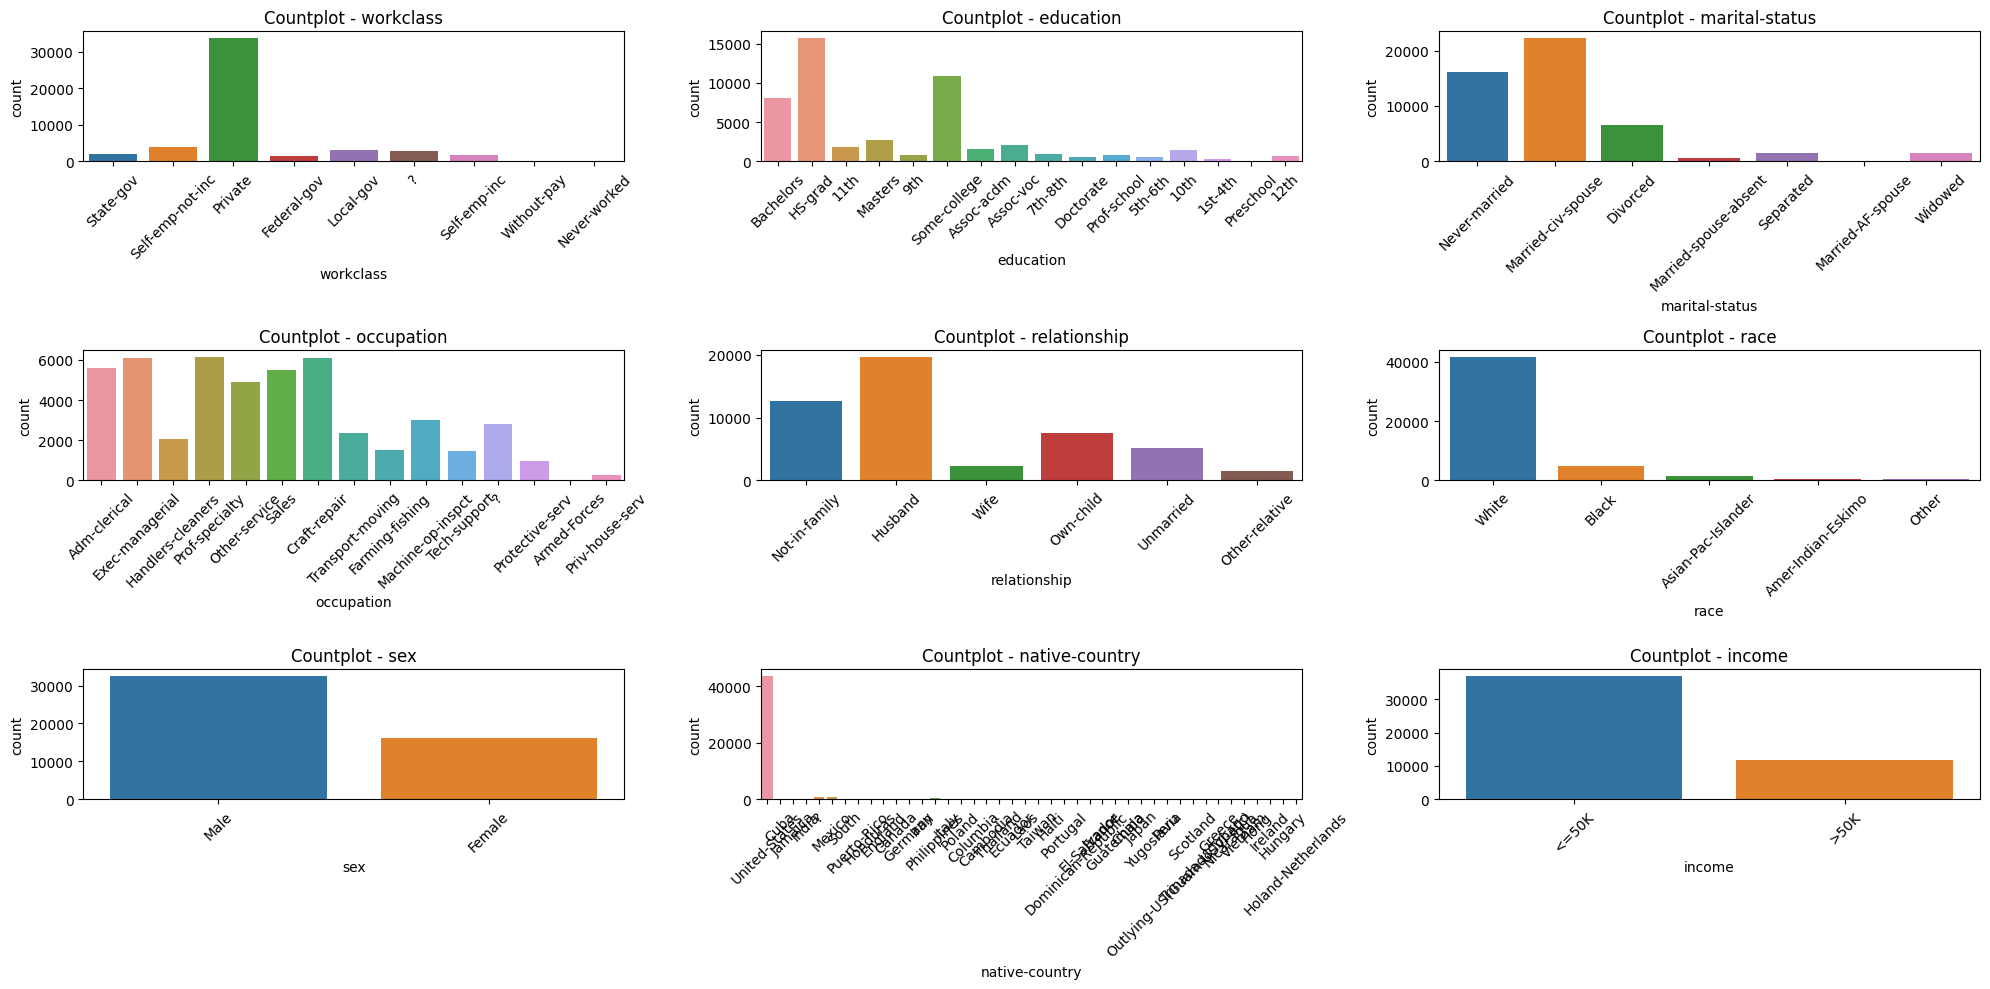

In [63]:
def plot_countplots(data, number_rows, number_columns, figsize):
    
    cat_columns = data.select_dtypes(include='object').columns
    
    number_cat_columns = len(cat_columns)
    
    fig, axis = plt.subplots(number_rows, number_columns, figsize=figsize)
    
    axis = axis.flatten()
    
    for i in range(number_cat_columns):
        if i < len(axis):
            sns.countplot(x=data[cat_columns[i]], ax=axis[i])
            axis[i].set_title(f'Countplot - {cat_columns[i]}')
            axis[i].tick_params(axis='x', rotation = 45)
    
    plt.tight_layout()
    plt.show()

plot_countplots(data, 3, 3, (20, 10))

In [64]:
data.drop(columns=['education-num'], inplace=True)

#### Some of the below data preprocessing came from my notebook submitted for the group coursework

#### To encode the categorical columns we first used one hot encoding, this was after reading about the risk of overfitting with label encoding and also previous experience when switching from label encoding to one hot increased accuracy of a model. Once encoded the data is then split into X and y

In [65]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

for column in X.select_dtypes(include=['object']).columns:
    one_hot_encoded = pd.get_dummies(X[column], prefix=column, dtype='int')
    
    X = pd.concat([X, one_hot_encoded], axis=1)
    
    X.drop(column, axis=1, inplace=True)

y = y.map({'<=50K': 0, '>50K': 1})

X = X.values 
y = y.values 

print(X.shape)

(48842, 107)


#### Split the data into train and test sets using 10% of the data for the test set. A validation set wasn't used because the data is being split during the stratified KFold process

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#### Normalise the data using the scikit learn StandardScaler to help prepare the data for training the multilayer perceptron and support vector machine. After this I will transform into tensors 

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [68]:
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.astype(np.float32)).unsqueeze(1)

#### Saving the processed data for use in the model later in the testing phase

#### I found out about joblib at this link https://stackoverflow.com/questions/72703709/save-and-reuse-ml-model and then read the joblib documentation 

#### I found out about saving the PyTorch tensors through the PyTorch documentation

In [69]:
torch.save(X_test_tensor, 'X_test_tensor.pt')
torch.save(y_test_tensor, 'y_test_tensor.pt')

joblib.dump(X_test_scaled, 'X_test_scaled.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

#### MultiLayer Perceptron with two hidden layers. The model uses a ReLU activation function, ReLU is used here because it is efficient to compute and helps to speed up training
#### Then a sigmoid activiaton function is used between the hidden and output layer, squashing the values between 0 and 1 which is used for a binary classification task
#### The structure of this model came from work done in labs throughout the module


In [70]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        X = self.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.sigmoid(self.fc2(X))

        return X


#### Due to code duplication, I decided to create a function to do the grid search, to enable grid searches to be done much easier
#### The method for sorting by the mean score came from this stack overflow explanation https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda

In [71]:
def grid_search_func(model_type, X_train_data, y_train_data, X_test_data, y_test_data, parameters):
    
    parameter_list = []
    mean_score = []
    
    if model_type == 'MLP':
        
        grid_search_model =  NeuralNetClassifier(
    module = MLP, 
    module__input_size = X_train_tensor.shape[1],
    module__output_size = 2,
    criterion = nn.CrossEntropyLoss, 
    optimizer = torch.optim.SGD, 
    max_epochs = 100, 
    callbacks = [EarlyStopping()],
    optimizer__weight_decay = 0.01
   
        )
        
        
        y_train_data = y_train_data.to(torch.long)
        y_train_data = y_train_data.flatten()

    elif model_type == 'SVM':
        
        grid_search_model = SVC()
        
    
    grid_search = GridSearchCV(grid_search_model, param_grid=parameters, scoring='accuracy', verbose=3, n_jobs=-1)
    
    grid_search.fit(X_train_data[:10000], y_train_data[:10000])
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_


    results = grid_search.cv_results_
    mean_test_scores = results['mean_test_score']
    parameters = results['params']
    
    y_pred = best_model.predict(X_test_data)

    accuracy = (y_pred == y_test_data).mean()


    print(f'Best Model - {best_model}')
    print(f'Best Parameters - {best_params}')
    print(f'Mean Test Scores - {mean_test_scores}')
    print(f'Accuracy - {accuracy}')
    
    results = grid_search.cv_results_

    for mean, parameter in zip(results['mean_test_score'], results['params']):
        parameter_list.append(parameter)
        mean_score.append(mean)
    
    sorted_data = sorted(zip(parameter_list, mean_score), key=lambda x: x[1], reverse=True)

    parameters_sorted, mean_scores_sorted = zip(*sorted_data)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(parameters_sorted)), mean_scores_sorted, color='skyblue')
    plt.yticks(range(len(parameters_sorted)), [str(param) for param in parameters_sorted])
    plt.xlabel('Mean Test Score')
    plt.ylabel('Parameters')
    plt.title('MLP Grid Search Results')
    plt.gca().invert_yaxis()
    plt.show()

#### Set the parameter dictionaries for MLP and SVM

In [72]:
mlp_parameters = { 
            'module__hidden_size': [64, 128, 256],
            'lr': [0.001, 0.01, 0.01],
            'optimizer__momentum'  : [0.0, 0.5, 0.9]
            
            }

In [73]:
svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf']
}


#### Train both of the models

Fitting 5 folds for each of 27 candidates, totalling 135 fits


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6293       0.7605        0.5844  0.1851
      2        0.5629       0.7605        0.5470  0.1643
      3        0.5388       0.7605        0.5312  0.1567
      4        0.5262       0.7605        0.5223  0.1859
      5        0.5181       0.7660        0.5155  0.1854
      6        0.5129       0.7940        0.5096  0.1968
      7        0.5062       0.8105        0.5040  0.2105
      8        0.5021       0.8210        0.4992  0.2328
      9        0.4978       0.8250        0.4952  0.2043
     10        0.4938       0.8325        0.4922  0.2274
     11        0.4929       0.8340        0.4900  0.2026
     12        0.4890       0.8360        0.4879  0.1824
     13        0.4871       0.8365        0.4863  0.1926
     14        0.4857       0.8365        0.4851  0.1927
     15        0.4831       0.8375        0.4840  0.2151
     16        0.4840       0.8

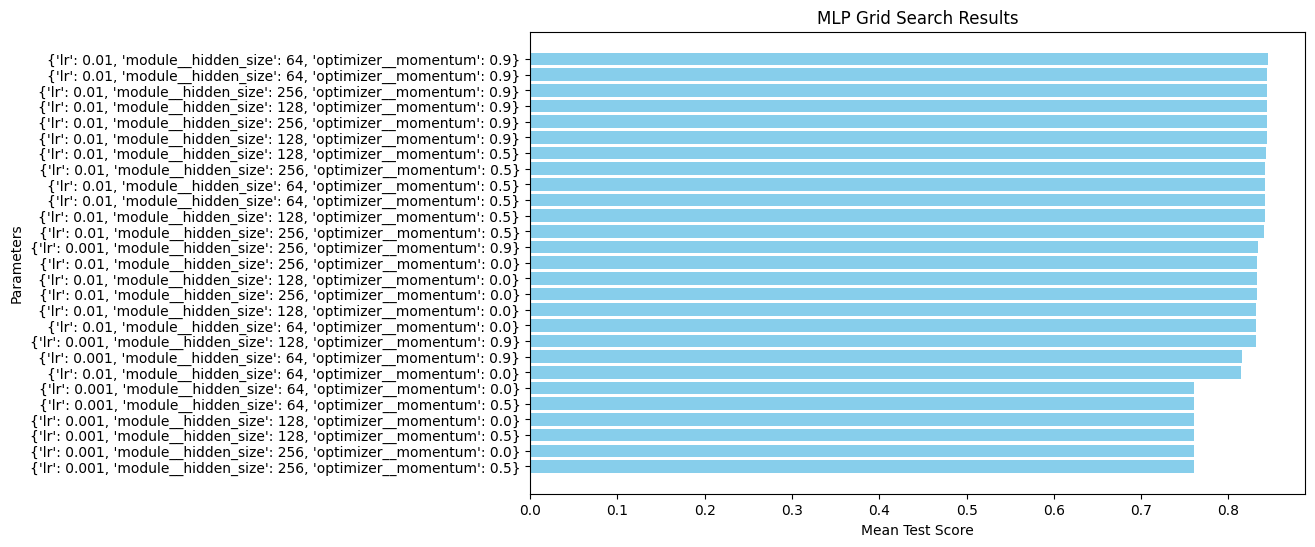

In [74]:
mlp_grid_search = grid_search_func('MLP', X_train_tensor, y_train_tensor, X_test_tensor, y_test, mlp_parameters)

#### Do the SVM grid search 
#### Visualise the accuracy of the different hyper parameter settings, C - 10 and gamma - 0.001 were most accurate by a small margin

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Model - SVC(C=10, gamma=0.001)
Best Parameters - {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Test Scores - [0.7754 0.8304 0.7819 0.7602 0.8304 0.8311 0.843  0.843  0.8167 0.786
 0.8437 0.8436 0.8492 0.8425 0.8108 0.7821 0.8421 0.843  0.8471 0.8263
 0.7983 0.7765 0.8271 0.8277]
Accuracy - 0.852200614124872


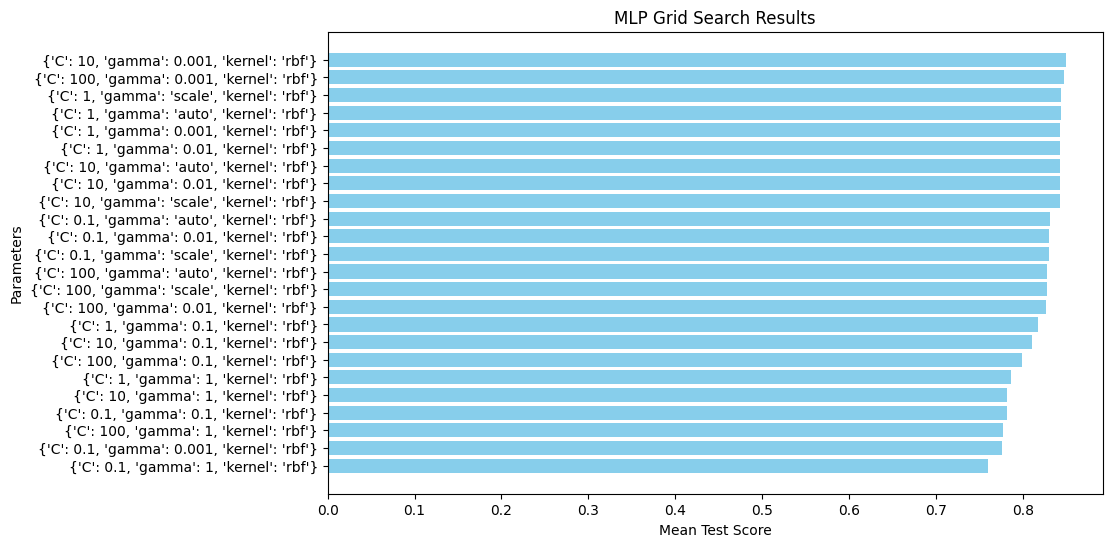

In [91]:
svm_grid_search = grid_search_func('SVM', X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters)

#### Because there was a lot of duplication in code when training the two models, especially around the recording of accuracies and visuals, I decided to turn the training and evaluation into a model with the hyperparameters as arguments
#### This enabled me to train the models easier, and if I wanted to I could keep changing hyperparameters and training models with just having to call the function
#### The idea to use the skorch wrapped came from one of the earlier labs for the module

In [84]:
def train_eval_model(model_type, X_train_data, y_train_data, hidden_size = None, output_size = None, epochs = None, learning_rate = None, optimizer_momentum=None, kernel=None, C=None, gamma=None):
    
    input_size = X_train_data.shape[1]
    
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    training_accuracies = []
    validation_accuracies = []
    train_confusion_matrices = []
    validation_confusion_matrices = []
    
    train_mean_fpr = np.linspace(0, 1, 100)
    tprs_train = []
    val_mean_fpr = np.linspace(0, 1 , 100)
    tprs_val = []
    
    fold_count = 1
    
    if model_type == 'MLP':
        
        model = NeuralNetClassifier(
            module=MLP, 
            module__input_size = input_size, 
            module__hidden_size = hidden_size,
            module__output_size = output_size, 
            criterion = nn.CrossEntropyLoss, 
            optimizer = torch.optim.SGD, 
            optimizer__lr = learning_rate, 
            optimizer__momentum = optimizer_momentum, 
            max_epochs = epochs, 
            callbacks=[EarlyStopping(patience=5)],
            optimizer__weight_decay = 0.01
        )
        
    elif model_type == 'SVM': 
        
        model = SVC(kernel=kernel, C=C, gamma=gamma)
        
    for train_index, validation_index in k_fold.split(X_train_data, y_train_data):
        
        X_train_fold, X_val_fold = X_train_data[train_index], X_train_data[validation_index]
        y_train_fold, y_val_fold = y_train_data[train_index], y_train_data[validation_index]
        
        print(f'Fold - {fold_count}')
        
        if model_type == 'MLP':
            
            X_val_fold = torch.tensor(X_val_fold).to(torch.float32)
            
            y_train_fold = y_train_fold.squeeze()
            y_train_fold = y_train_fold.to(torch.long)
            y_val_fold = y_val_fold.squeeze()
            y_val_fold = y_val_fold.to(torch.long)
        
        model.fit(X_train_fold, y_train_fold)
        
        ## Calculating accuracies for training data 
        
        y_train_prediction = model.predict(X_train_fold)
        
        training_accuracy = accuracy_score(y_train_prediction, y_train_fold)
        
        training_accuracies.append(training_accuracy)
        
        ## Confusion Matrix for training data
        
        train_fold_confusion_matrix = confusion_matrix(y_train_fold, y_train_prediction)
        
        train_confusion_matrices.append(train_fold_confusion_matrix)
        
        ## ROC Curve for training data 
        
        fpr_train, tpr_train, _ = roc_curve(y_train_fold, y_train_prediction)
        
        tprs_train.append(np.interp(train_mean_fpr, fpr_train, tpr_train))
        
        tprs_train[-1][0] = 0.0 
        
        ## Calculating accuracies for validation data 
        
        y_val_prediction = model.predict(X_val_fold)
        
        val_accuracy = accuracy_score(y_val_prediction, y_val_fold)
        
        validation_accuracies.append(val_accuracy)
        
        ## Confusion Matrix for training data
        
        val_fold_confusion_matrix = confusion_matrix(y_val_fold, y_val_prediction)
        
        validation_confusion_matrices.append(val_fold_confusion_matrix)
        
        ## ROC Curve for training data 
        
        fpr_val, tpr_val, _ = roc_curve(y_val_fold, y_val_prediction)
        
        tprs_val.append(np.interp(val_mean_fpr, fpr_val, tpr_val))
           
        tprs_val[-1][0] = 0.0 
        
        fold_count += 1

    mean_training_accuracy = np.mean(training_accuracies)
    
    mean_validation_accuracy = np.mean(validation_accuracies)
    
    train_summed_confusion_matrix = np.sum(train_confusion_matrices, axis=0)
    
    val_summed_confusion_matrix = np.sum(validation_confusion_matrices, axis=0)
    
    mean_tpr_train = np.mean(tprs_train, axis=0)
    
    mean_auc_train = auc(train_mean_fpr, mean_tpr_train)
    
    mean_tpr_val = np.mean(tprs_val, axis=0)
    
    mean_auc_val = auc(val_mean_fpr, mean_tpr_val)
    
    print(f'Mean training accuracy - {mean_training_accuracy}. Mean Validation Accuracy - {mean_validation_accuracy}')
    
    plt.figure(figsize=(18, 12))     
    
    plt.subplot(2, 2, 1)
    sns.heatmap(train_summed_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix - Training Dataset')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    
    plt.subplot(2, 2, 2)
    plt.plot(train_mean_fpr, mean_tpr_train, color='b', label = f'Mean ROC (AUC - {mean_auc_train:.2f})')
    plt.plot([0,1], [0,1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Training Dataset')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    
    plt.subplot(2, 2, 3)
    sns.heatmap(val_summed_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix - Validation Dataset')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    
    plt.subplot(2, 2, 4)
    plt.plot(val_mean_fpr, mean_tpr_val, color='b', label = f'Mean ROC (AUC - {mean_auc_val:.2f})')
    plt.plot([0,1], [0,1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Validation Dataset')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    plt.tight_layout()
    
    plt.show()
    
    
    return model

#### Training the MLP model using the train_eval_model function, setting the hyperparameters from the grid search above

Fold - 1


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5712       0.7604        0.5242  1.1919
      2        0.5143       0.8191        0.5017  1.0844
      3        0.4973       0.8362        0.4892  0.6170
      4        0.4898       0.8398        0.4839  0.6323
      5        0.4852       0.8416        0.4811  0.5813
      6        0.4831       0.8420        0.4793  0.5814
      7        0.4811       0.8423        0.4781  0.5623
      8        0.4801       0.8423        0.4774  0.6081
      9        0.4793       0.8427        0.4770  0.6407
     10        0.4789       0.8427        0.4767  0.6774
     11        0.4787       0.8432        0.4763  0.6375
     12        0.4783       0.8429        0.4761  0.6583
     13        0.4777       0.8437        0.4760  0.6999
     14        0.4776       0.8429        0.4758  0.6349
     15        0.4778       0.8437        0.4756  0.6281
     16        0.4767       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5761       0.7606        0.5267  0.7584
      2        0.5171       0.8092        0.5036  0.6799
      3        0.5001       0.8383        0.4894  0.6383
      4        0.4901       0.8402        0.4829  0.6699
      5        0.4854       0.8410        0.4797  0.6728
      6        0.4837       0.8416        0.4781  0.6407
      7        0.4817       0.8416        0.4769  0.6245
      8        0.4808       0.8416        0.4763  0.6367
      9        0.4806       0.8412        0.4759  0.6813
     10        0.4796       0.8426        0.4754  0.6395
     11        0.4793       0.8422        0.4750  0.6128
     12        0.4783       0.8427        0.4748  0.6429
     13        0.4785       0.8426        0.4745  0.6680
     14        0.4787       0.8433        0.4745  0.6498
     15        0.4784       0.8432        0.4742  0.6020
     16        0.4775       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5700       0.7630        0.5232  0.6584
      2        0.5125       0.8249        0.4996  0.6101
      3        0.4958       0.8378        0.4874  0.5913
      4        0.4886       0.8403        0.4825  0.6277
      5        0.4859       0.8401        0.4803  0.6588
      6        0.4838       0.8411        0.4788  0.6348
      7        0.4828       0.8409        0.4782  0.6463
      8        0.4823       0.8412        0.4777  0.6693
      9        0.4811       0.8422        0.4770  0.6366
     10        0.4811       0.8418        0.4769  0.6432
     11        0.4803       0.8436        0.4765  0.7199
     12        0.4796       0.8436        0.4762  0.5923
     13        0.4792       0.8439        0.4760  0.6781
     14        0.4794       0.8439        0.4760  0.6587
     15        0.4791       0.8442        0.4759  0.6542
     16        0.4786       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5808       0.7603        0.5282  0.6311
      2        0.5178       0.8203        0.5025  0.6791
      3        0.4988       0.8440        0.4879  0.6322
      4        0.4900       0.8445        0.4815  0.6336
      5        0.4851       0.8463        0.4784  0.6231
      6        0.4831       0.8460        0.4769  0.6342
      7        0.4817       0.8456        0.4760  0.6677
      8        0.4809       0.8459        0.4753  0.6247
      9        0.4796       0.8460        0.4747  0.6234
     10        0.4781       0.8462        0.4743  0.7595
     11        0.4787       0.8463        0.4739  1.0558
     12        0.4780       0.8462        0.4738  0.8693
     13        0.4775       0.8465        0.4735  0.8774
     14        0.4771       0.8470        0.4733  0.7650
     15        0.4770       0.8462        0.4732  0.6594
     16        0.4770       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5740       0.7622        0.5236  0.6760
      2        0.5134       0.8276        0.4991  0.6100
      3        0.4961       0.8428        0.4860  0.6268
      4        0.4878       0.8442        0.4803  0.6482
      5        0.4833       0.8449        0.4775  0.6181
      6        0.4808       0.8452        0.4760  0.5860
      7        0.4799       0.8456        0.4751  0.6345
      8        0.4784       0.8472        0.4743  0.6834
      9        0.4779       0.8476        0.4738  0.6641
     10        0.4779       0.8485        0.4738  0.6601
     11        0.4766       0.8472        0.4733  0.6607
     12        0.4772       0.8479        0.4730  0.6651
     13        0.4761       0.8477        0.4729  0.6122
     14        0.4760       0.8476        0.4727  0.6165
     15        0.4759       0.8479        0.4727  0.6472
     16        0.4758       0.8

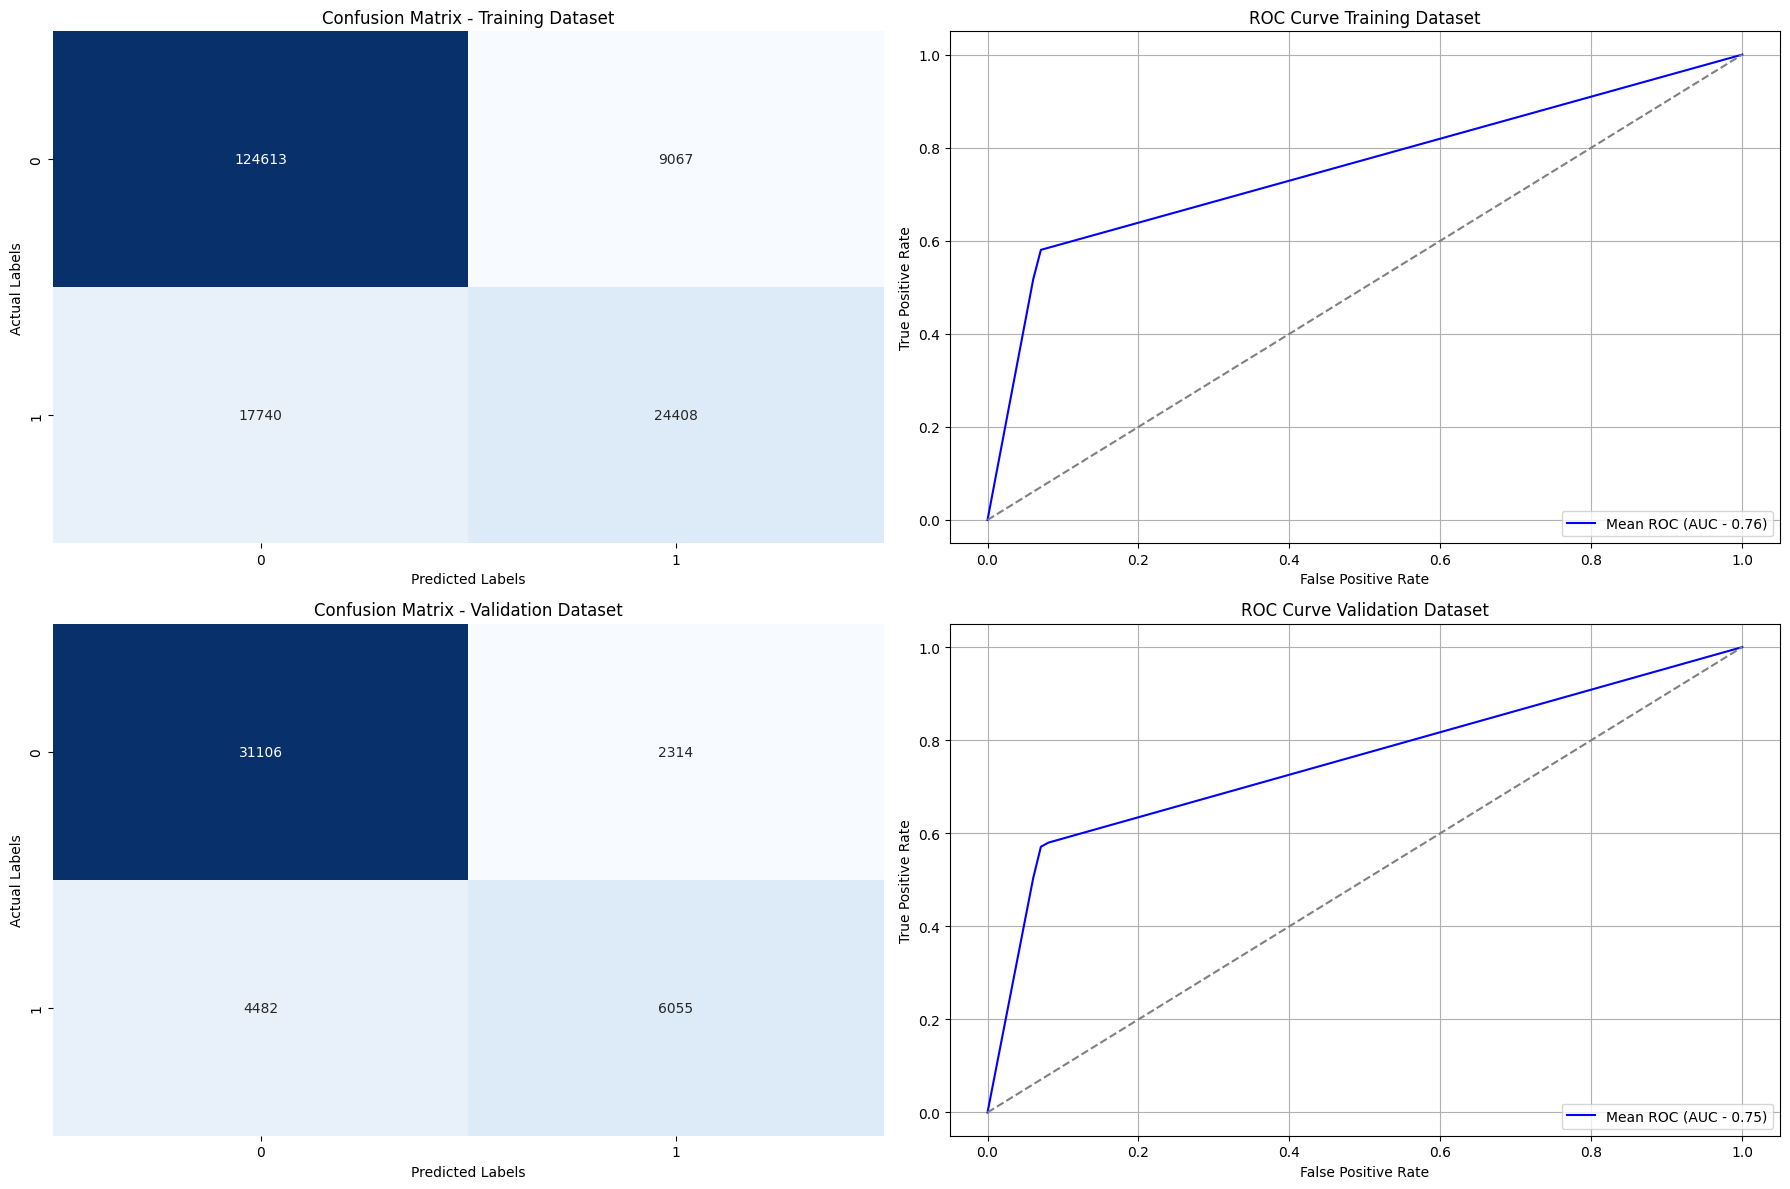

In [85]:
mlp = train_eval_model('MLP', X_train_tensor, y_train_tensor, hidden_size=64, output_size=2, epochs=250, learning_rate=0.01, optimizer_momentum=0.9)

In [86]:
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_resampled = torch.tensor(X_train_resampled.astype(np.float32))
y_train_resampled = torch.tensor(y_train_resampled.astype(np.float32))

#### Training the SMOTE model using the train_eval_model function. The results weren't too good, the accuracy was a few percent below the previous MLP model

Fold - 1


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5909       0.6051        0.6311  1.2038
      2        0.5263       0.7652        0.5549  0.9784
      3        0.5118       0.7777        0.5411  0.9741
      4        0.5055       0.7810        0.5374  0.9427
      5        0.5043       0.7822        0.5364  1.0492
      6        0.5030       0.7833        0.5356  0.9647
      7        0.5015       0.7836        0.5352  1.0026
      8        0.5016       0.7847        0.5348  0.9551
      9        0.5008       0.7849        0.5344  1.0016
     10        0.5012       0.7850        0.5344  1.0494
     11        0.5005       0.7853        0.5342  1.0815
     12        0.5007       0.7856        0.5340  0.9796
     13        0.5000       0.7849        0.5341  0.9366
     14        0.4999       0.7852        0.5340  1.0027
     15        0.4992       0.7849        0.5336  0.9300
     16        0.4992       0.7

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5849       0.6141        0.6312  1.0486
      2        0.5300       0.7653        0.5542  1.0285
      3        0.5144       0.7767        0.5405  1.0584
      4        0.5083       0.7811        0.5371  0.9658
      5        0.5047       0.7830        0.5349  0.9515
      6        0.5044       0.7835        0.5343  1.0224
      7        0.5028       0.7835        0.5339  0.9822
      8        0.5013       0.7843        0.5332  0.9601
      9        0.5013       0.7849        0.5330  0.9681
     10        0.5000       0.7849        0.5327  0.9357
     11        0.4993       0.7849        0.5322  1.0267
     12        0.4991       0.7848        0.5321  0.9798
     13        0.4981       0.7850        0.5316  1.0046
     14        0.4980       0.7853        0.5312  0.9949
     15        0.4977       0.7853        0.5314  0.9728
     16        0.4978       0.7

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5690       0.6655        0.6164  0.9566
      2        0.5267       0.7656        0.5547  1.0015
      3        0.5127       0.7739        0.5427  1.0036
      4        0.5069       0.7776        0.5388  0.9617
      5        0.5025       0.7790        0.5371  0.9503
      6        0.5019       0.7801        0.5362  0.9255
      7        0.5003       0.7812        0.5359  0.9700
      8        0.4995       0.7819        0.5354  0.8928
      9        0.4982       0.7820        0.5349  0.9154
     10        0.4974       0.7820        0.5345  0.9151
     11        0.4971       0.7826        0.5343  0.9188
     12        0.4968       0.7825        0.5344  0.9255
     13        0.4967       0.7832        0.5340  1.0537
     14        0.4963       0.7835        0.5339  0.9343
     15        0.4962       0.7835        0.5336  0.9022
     16        0.4960       0.7

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5784       0.6319        0.6273  0.8899
      2        0.5278       0.7615        0.5566  0.9225
      3        0.5130       0.7713        0.5434  0.9706
      4        0.5055       0.7752        0.5393  0.9729
      5        0.5025       0.7773        0.5374  1.0014
      6        0.5011       0.7789        0.5364  1.0039
      7        0.4995       0.7795        0.5362  0.9173
      8        0.5003       0.7812        0.5356  0.9167
      9        0.4987       0.7813        0.5352  0.9103
     10        0.4979       0.7810        0.5352  0.9394
     11        0.4968       0.7815        0.5347  0.9255
     12        0.4972       0.7812        0.5346  0.9338
     13        0.4975       0.7818        0.5345  0.9194
     14        0.4970       0.7816        0.5344  0.9521
     15        0.4968       0.7819        0.5344  0.9826
     16        0.4966       0.7

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_16000\3950850835.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5766       0.6400        0.6228  1.0206
      2        0.5254       0.7678        0.5525  1.0032
      3        0.5114       0.7780        0.5395  0.9966
      4        0.5054       0.7816        0.5359  0.9757
      5        0.5034       0.7840        0.5339  0.9521
      6        0.5013       0.7848        0.5335  0.9789
      7        0.4999       0.7854        0.5329  0.9602
      8        0.4986       0.7860        0.5326  0.9073
      9        0.4986       0.7859        0.5321  1.0075
     10        0.4982       0.7871        0.5317  0.9833
     11        0.4980       0.7869        0.5318  0.9810
     12        0.4976       0.7878        0.5315  0.9885
     13        0.4972       0.7880        0.5312  0.9603
     14        0.4973       0.7880        0.5313  1.0252
     15        0.4974       0.7876        0.5313  1.0206
     16        0.4971       0.7

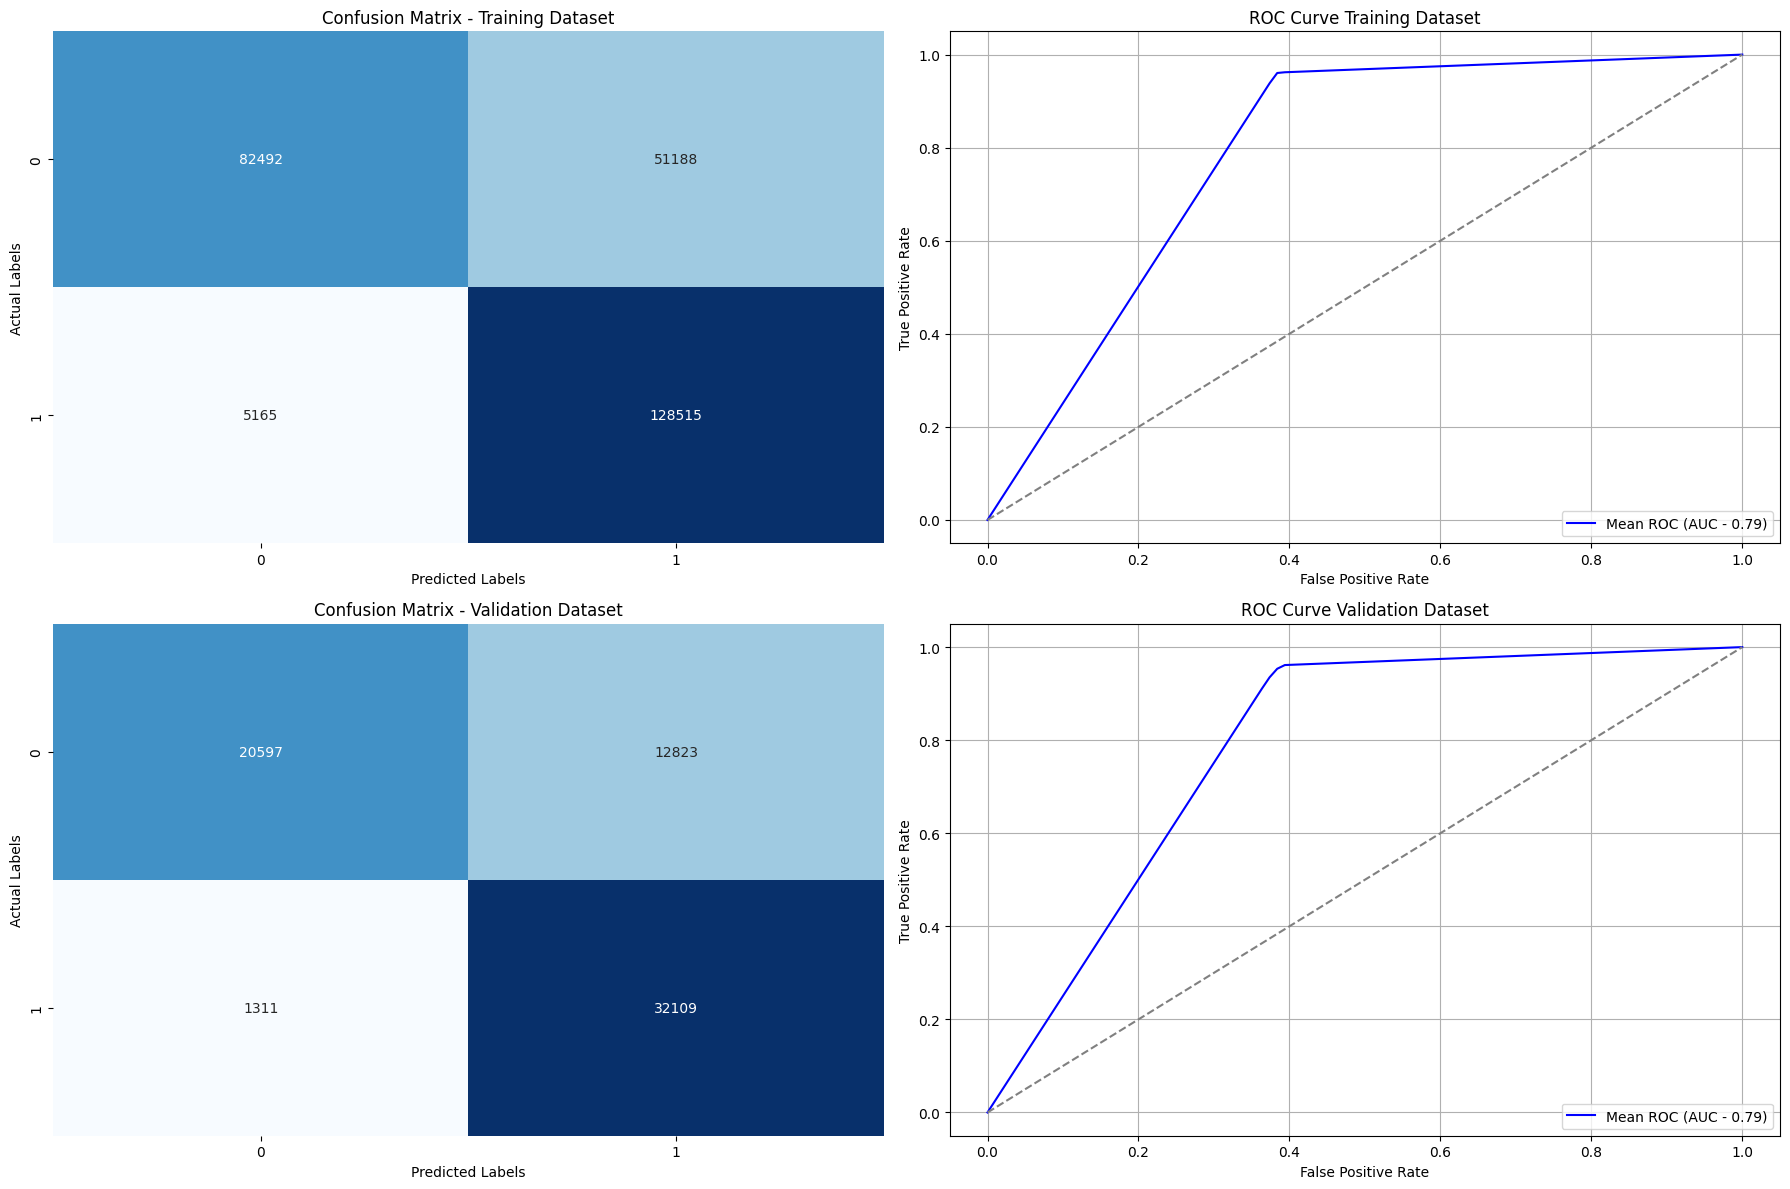

In [87]:
smote_model = train_eval_model('MLP', X_train_resampled, y_train_resampled, hidden_size=64, output_size=2, epochs=250, learning_rate=0.01, optimizer_momentum=0.9)

#### Training the svm model using the train_eval_model function

Fold - 1
Fold - 2
Fold - 3
Fold - 4
Fold - 5
Mean training accuracy - 0.8599540439668407. Mean Validation Accuracy - 0.8520143983594769


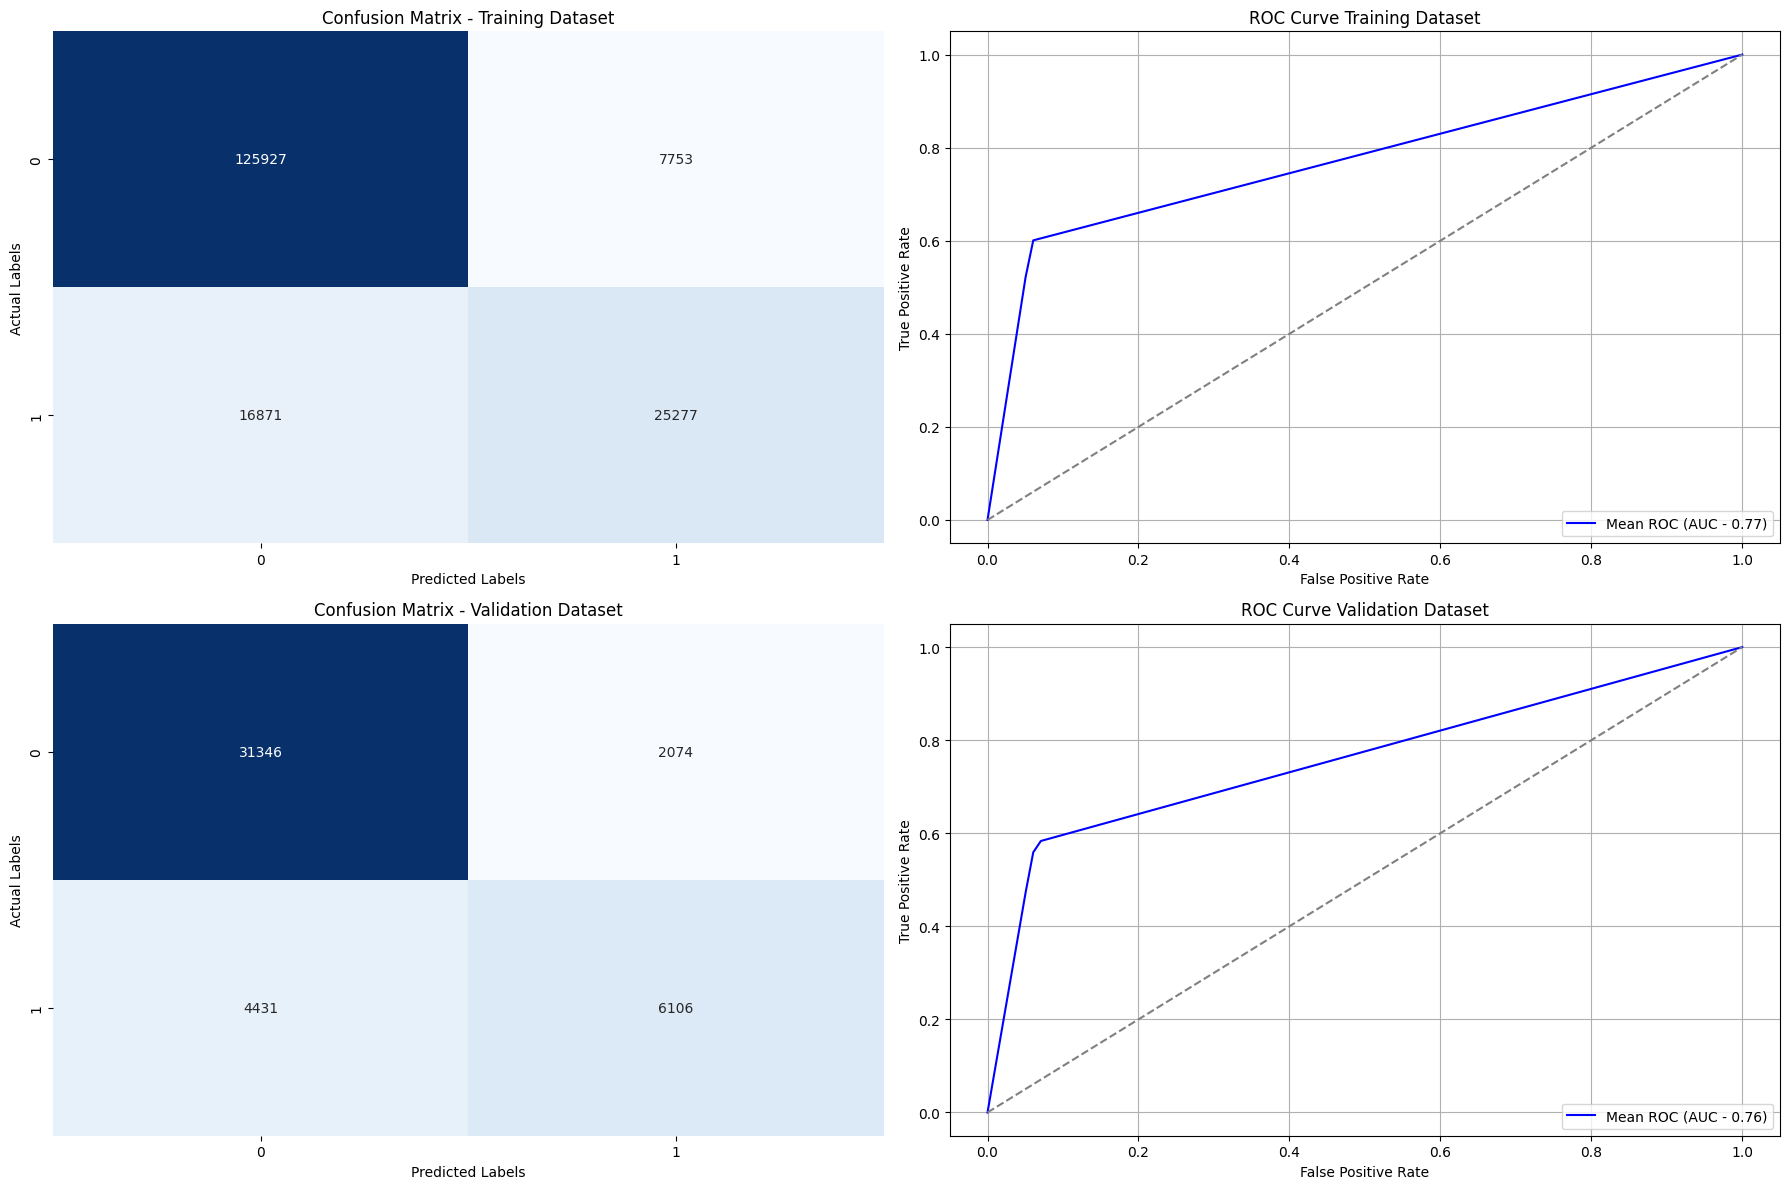

In [88]:
svm = train_eval_model('SVM', X_train_scaled, y_train, kernel='rbf', C=10, gamma=0.001)

#### Finally I saved both of the trained models using joblib, for use in the test script

In [89]:
joblib.dump(svm, 'trained_svm.pkl')
joblib.dump(mlp, 'trained_mlp.pkl')

['trained_mlp.pkl']